
## Import necessary libraries

In [1]:
import torch

# Verifica si CUDA (GPU) está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')


# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

C:\Users\luisl\AppData\Local\Temp\ipykernel_16516\269888456.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

## cargar texto resumido 

In [4]:
import pickle

# Define the path to the pickle file (same as before)
ruta_pickle = 'C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/data/preprocessed/text_resumido_v2_completo.pkl'

# Open the file in binary read mode
with open(ruta_pickle, 'rb') as pickle_file:
  # Use pickle.load to deserialize the data and create a new DataFrame
  loaded_df = pickle.load(pickle_file)

print("¡DataFrame cargado del archivo pickle exitosamente!")

¡DataFrame cargado del archivo pickle exitosamente!


In [5]:
loaded_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,I think it's better to take them up later in t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,I am distressed about what happened after the ...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...,I thought we might change the order [of the ag...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro...",Everybody in this room has a significantly hig...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ...",I don't know that we've been that precise abou...


In [6]:
train_sent_df = loaded_df

In [7]:
import pandas as pd

# Porcentaje deseado de las filas (e.g., 10%)
porcentaje = 100

# Calcula el número de filas a seleccionar basado en el porcentaje
num_filas = int(len(train_sent_df) * (porcentaje / 100))

# Selecciona aleatoriamente el porcentaje deseado de filas del DataFrame
submuestra_df = train_sent_df.sample(n=num_filas)

submuestra_df = submuestra_df.dropna(subset=['next_decision'])

# Convierte la columna deseada a una lista
X_submuestra = submuestra_df['summary'].to_list()



carga del primer modelo reentrenado

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Define labels
labels = ['negative', 'neutral', 'positive']

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Define the path to the saved model (assuming the model is saved in a folder)
model_path = "C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/models/best_model_5e-05_64_V2.pt"  # Replace with your actual path

# Function to preprocess text
def preprocess_text(text, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs.input_ids.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    attention_mask = inputs.attention_mask.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    return input_ids, attention_mask

# Load the model
model_finbert = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model_finbert.load_state_dict(torch.load(model_path))
model_finbert.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move to GPU if available

with torch.no_grad():
    model_finbert.eval()

    # Example usage
    text = "The stock market is booming!"
    input_ids, attention_mask = preprocess_text(text, tokenizer)

    # Get predictions
    outputs = model_finbert(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Get the predicted sentiment
    predicted_sentiment = labels[predicted_label]

    print(f"Predicted sentiment for '{text}': {predicted_sentiment}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted sentiment for 'The stock market is booming!': positive


twitter-roberta-base-sentiment Model¶


In [9]:
import torch
import numpy as np
import scipy.special
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Cargar el tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model_roberta = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model_roberta.load_state_dict(torch.load(model_path))
model_roberta.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)

tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
labels = ['negative', 'neutral', 'positive']

# Asumiendo que X_submuestra es tu lista de textos a analizar
preds_roberta = []
preds_proba_roberta = []

for x in tqdm(X_submuestra, desc="Procesando predicciones"):
    with torch.no_grad():
        # Tokenizar y mover el texto completo a la GPU
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs).to(device)
        # Obtener las logits del modelo
        logits = model_roberta(**input_sequence).logits
        # Aplicar softmax en la GPU
        scores = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
    
    sentimiento_general = labels[np.argmax(scores)]
    probabilidad_general = np.max(scores)
    
    preds_roberta.append(sentimiento_general)
    preds_proba_roberta.append(probabilidad_general)


Procesando predicciones: 100%|██████████| 4597/4597 [04:57<00:00, 15.47it/s]


In [10]:
submuestra_df['predicted_roberta'] = preds_roberta; submuestra_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary,predicted_roberta
7,statement,1995-07-06,FOMC Statement,Alan Greenspan,67,-1,5.75,1995-08-22,0,5.75,Chairman Alan Greenspan announced today that t...,I don't know whether these views that are expr...,positive
1416,presconf_script,2020-07-29,FOMC Press Conference Transcript,Jerome Powell,1175,0,0.00,2020-08-27,0,0.00,"Not that I'm aware of, no. MICHELLE SMITH. Tha...",Powell: Pandemic unemployment benefits could b...,neutral
12702,speech,2006-06-12,A Supervisorâs Perspective on Enterprise Ris...,Governor Susan Schmidt Bies,3312,<NA>,NaN,2006-06-29,1,5.25,Today I will look at some recent cases in whic...,The Federal Reserve has long emphasized the ne...,positive
13446,speech,2019-10-17,Opening Remarks,Governor Michelle W. Bowman,908,<NA>,NaN,2019-10-30,-1,1.50,"Thank you, President Evans, for hosting this e...",Last in series of Fed Listens events held acro...,neutral
12780,speech,2007-09-10,Outlook and Risks for the U.S. Economy,Governor Frederic S. Mishkin,2960,<NA>,NaN,2007-09-18,-1,4.75,Thank you for the invitation to be here this e...,Tomorrow marks the sixth anniversary of the te...,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,340,0,0.00,2012-03-13,0,0.00,"Well, there are a number of factors that make ...","Bernanke: We are seeing a reversal, or at leas...",neutral
1058,presconf_script,2019-01-30,FOMC Press Conference Transcript,BINYAMIN APPELBAUM,87,0,2.25,2019-03-20,0,2.25,"Binya Appelbaum, New York Times. I am struggli...",I am struggling a little bit to understand wha...,neutral
253,meeting_script,2014-04-30,FOMC Meeting Transcript,,78299,0,0.00,2014-06-18,0,0.00,"Good morning, everybody. Unfortunately, this i...",Sandy began attending FOMC meetings in 1993 as...,neutral
13977,testimony,2008-04-17,Credit cards,"Sandra F. Braunstein, Director, Division of Co...",2674,<NA>,NaN,2008-04-30,-1,2.00,"Madam Chair Maloney, Ranking Member Biggert, m...",Federal Reserve Board is working to enhance pr...,negative


In [11]:
submuestra_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary,predicted_roberta
7,statement,1995-07-06,FOMC Statement,Alan Greenspan,67,-1,5.75,1995-08-22,0,5.75,Chairman Alan Greenspan announced today that t...,I don't know whether these views that are expr...,positive
1416,presconf_script,2020-07-29,FOMC Press Conference Transcript,Jerome Powell,1175,0,0.00,2020-08-27,0,0.00,"Not that I'm aware of, no. MICHELLE SMITH. Tha...",Powell: Pandemic unemployment benefits could b...,neutral
12702,speech,2006-06-12,A Supervisorâs Perspective on Enterprise Ris...,Governor Susan Schmidt Bies,3312,<NA>,NaN,2006-06-29,1,5.25,Today I will look at some recent cases in whic...,The Federal Reserve has long emphasized the ne...,positive
13446,speech,2019-10-17,Opening Remarks,Governor Michelle W. Bowman,908,<NA>,NaN,2019-10-30,-1,1.50,"Thank you, President Evans, for hosting this e...",Last in series of Fed Listens events held acro...,neutral
12780,speech,2007-09-10,Outlook and Risks for the U.S. Economy,Governor Frederic S. Mishkin,2960,<NA>,NaN,2007-09-18,-1,4.75,Thank you for the invitation to be here this e...,Tomorrow marks the sixth anniversary of the te...,negative


In [12]:
selected_columns_df = submuestra_df[['date', 'predicted_roberta', 'next_meeting','next_decision']]

In [13]:
# Define el diccionario de mapeo
mapping = {'negative': -1, 'positive': 1, 'neutral': 0}

# Reemplaza los valores en la columna 'predicted_roberta'
selected_columns_df['predicted_roberta'] = selected_columns_df['predicted_roberta'].replace(mapping)

In [14]:
selected_columns_df.head()

,date,predicted_roberta,next_meeting,next_decision
7,1995-07-06,1,1995-08-22,0
1416,2020-07-29,0,2020-08-27,0
12702,2006-06-12,1,2006-06-29,1
13446,2019-10-17,0,2019-10-30,-1
12780,2007-09-10,-1,2007-09-18,-1


Cargar datos numericos

In [15]:
# Load previously processed non-text data
# Load data
file = open('C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/data/train_data/nontext_train_small.pickle', 'rb')
train_df = pickle.load(file)
file.close()

print(train_df.shape)
train_df

(403, 13)


,target,RateDiff,prev_decision,Employ_diff_year,Rsales_diff_year,Unemp_diff_year,Employ_diff_prev,GDP_diff_year,PCE_diff_prev,Unemp_diff_prev,Hsales_diff_year,GDP_diff_prev,Taylor
date,,,,,,,,,,,,,
1982-10-05,-1,-0.50,0,-2294.0,2.004317,-2.5,-180.0,-1.010745,0.460401,-0.3,42.307692,0.456177,11.061999
1982-11-16,-1,-0.50,-1,-2473.0,2.004317,-2.5,-276.0,-2.556042,0.370245,-0.3,34.831461,-0.382267,10.045779
1982-12-21,0,0.00,-1,-2385.0,2.004317,-2.5,-121.0,-2.556042,0.634292,-0.4,45.026178,-0.382267,10.105638
1983-01-14,0,0.00,0,-2124.0,2.004317,-2.3,-15.0,-2.556042,0.368789,0.0,14.004376,-0.382267,9.766001
1983-01-21,0,0.00,0,-2124.0,2.004317,-2.3,-15.0,-2.556042,0.368789,0.0,14.004376,-0.382267,9.766001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-14,0,0.00,1,3928.0,-1.938580,-0.1,281.0,1.717927,0.306901,-0.3,11.635220,0.556381,12.123858
2023-07-26,1,0.25,0,3663.0,-1.573436,0.0,105.0,1.717927,0.288262,0.1,21.314387,0.556381,12.011106
2023-09-20,0,0.00,1,3144.0,-0.840916,-0.1,165.0,2.382468,0.119978,-0.3,2.507837,0.511122,11.295164


In [16]:
train_df.reset_index(inplace=True)

In [17]:
train_df.columns

Index(['date', 'target', 'RateDiff', 'prev_decision', 'Employ_diff_year',
       'Rsales_diff_year', 'Unemp_diff_year', 'Employ_diff_prev',
       'GDP_diff_year', 'PCE_diff_prev', 'Unemp_diff_prev', 'Hsales_diff_year',
       'GDP_diff_prev', 'Taylor'],
      dtype='object')

unir los dos datasets, ponderando entre fechas el sentimientyo medio

In [40]:
df1= selected_columns_df
df2 = train_df

In [41]:
import pandas as pd
import numpy as np

# Crea una lista para almacenar los datos fusionados
merged_data = []

# Itera sobre cada fila de df1
for index, row in df1.iterrows():
    # Verifica si 'next_meeting' es un valor NaN o si no es del tipo datetime
    if pd.isnull(row['next_meeting']) or not isinstance(row['next_meeting'], pd.Timestamp):
        continue  # Salta esta fila si 'next_meeting' no es válido
    
    # Filtra df1 para las fechas en el rango definido por la fila actual de df1
    subset_df1 = df1[(df1['date'] >= row['date']) & (df1['date'] <= row['next_meeting'])]
    
    # Calcula el promedio de 'predicted_roberta' en el rango de fechas
    predicted_roberta_avg = subset_df1['predicted_roberta'].mean()
    
    # Añade los datos al resultado fusionado
    merged_data.append({
        'date': row['date'],
        'predicted_roberta': predicted_roberta_avg
    })

# Crea un DataFrame a partir de la lista de datos fusionados
merged_df = pd.DataFrame(merged_data)

# Fusiona 'merged_df' con 'df2' en la columna 'date'
merged_df = pd.merge(merged_df, df2, on='date', how='inner')

# Ordena el DataFrame por la columna 'date'
merged_df = merged_df.sort_values(by='date')




In [42]:

# Ordena el DataFrame por la columna 'date'
merged_df = merged_df.sort_values(by='date')

In [43]:
# Elimina las filas duplicadas del DataFrame
merged_df.drop_duplicates(inplace=True)

# Ordena el DataFrame por la columna 'date'
merged_df = merged_df.sort_values(by='date')


In [44]:
merged_df.head()

,date,predicted_roberta,target,RateDiff,prev_decision,Employ_diff_year,Rsales_diff_year,Unemp_diff_year,Employ_diff_prev,GDP_diff_year,PCE_diff_prev,Unemp_diff_prev,Hsales_diff_year,GDP_diff_prev,Taylor
854,1982-10-05,-0.5,-1,-0.500,0,-2294.0,2.004317,-2.5,-180.0,-1.010745,0.460401,-0.3,42.307692,0.456177,11.061999
914,1982-11-16,0.0,-1,-0.500,-1,-2473.0,2.004317,-2.5,-276.0,-2.556042,0.370245,-0.3,34.831461,-0.382267,10.045779
212,1982-12-21,1.0,0,0.000,-1,-2385.0,2.004317,-2.5,-121.0,-2.556042,0.634292,-0.4,45.026178,-0.382267,10.105638
300,1983-02-09,0.0,0,0.000,0,-1575.0,2.004317,-1.8,219.0,-1.443184,0.318443,0.4,58.152174,0.040009,9.324123
1674,1983-03-29,0.0,1,0.125,0,-1646.0,2.004317,-1.5,-73.0,-1.443184,0.683700,0.0,53.972603,0.040009,9.435454


In [45]:
#merged_df.drop(columns=['level_0', 'index'], inplace=True)

In [46]:
# Realiza la fusión de los DataFrames por la columna 'date'
merged_df = pd.merge(merged_df, df1[['date', 'next_meeting', 'next_decision']], on='date', how='inner')

# Ordena el DataFrame por la columna 'date'
merged_df = merged_df.sort_values(by='date')

In [47]:
# Elimina las filas duplicadas del DataFrame
merged_df.drop_duplicates(inplace=True)

df unificado

In [48]:
merged_df.shape

(328, 17)

In [49]:
merged_df.drop(columns=['target', 'next_meeting'], inplace=True)

In [50]:
merged_df.tail()

,date,predicted_roberta,RateDiff,prev_decision,Employ_diff_year,Rsales_diff_year,Unemp_diff_year,Employ_diff_prev,GDP_diff_year,PCE_diff_prev,Unemp_diff_prev,Hsales_diff_year,GDP_diff_prev,Taylor,next_decision
2264,2023-05-03,0.105263,0.25,1,4048.0,-2.662041,0.1,217.0,1.717927,0.335926,0.1,-9.476662,0.556381,12.153794,0
2291,2023-06-14,0.087912,0.00,1,3928.0,-1.938580,-0.1,281.0,1.717927,0.306901,-0.3,11.635220,0.556381,12.123858,1
2339,2023-07-26,0.126437,0.25,0,3663.0,-1.573436,0.0,105.0,1.717927,0.288262,0.1,21.314387,0.556381,12.011106,0
2372,2023-09-20,0.084211,0.00,1,3144.0,-0.840916,-0.1,165.0,2.382468,0.119978,-0.3,2.507837,0.511122,11.295164,0
2411,2023-11-01,0.022727,0.00,0,3056.0,0.295139,-0.3,262.0,2.926887,0.329011,0.0,23.456790,1.193871,10.970821,0


prediccion con LSTM

In [53]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [58]:
merged_df['prev_decision'] = merged_df['prev_decision'].astype(str)


In [76]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# Perform one-hot encoding on prev_decision
X = pd.get_dummies(merged_df.drop(['next_decision', 'date'], axis=1), columns=['prev_decision'])

# Assuming df is your DataFrame containing the dataset

# Step 1: Data Preprocessing
X = pd.get_dummies(merged_df.drop(['next_decision','date'], axis=1), columns=['prev_decision'])
y = merged_df['next_decision']

# Convert y to one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=3)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define Model Architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Step 3: Compile the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Training
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

# Step 5: Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5251 - loss: 265.5501 - val_accuracy: 0.5849 - val_loss: 167.6692
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6572 - loss: 108.4385 - val_accuracy: 0.4717 - val_loss: 22.3005
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4153 - loss: 30.2675 - val_accuracy: 0.3396 - val_loss: 50.5796
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4569 - loss: 35.4585 - val_accuracy: 0.5849 - val_loss: 33.4078
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6747 - loss: 26.1729 - val_accuracy: 0.5283 - val_loss: 9.8664
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3982 - loss: 12.4007 - val_accuracy: 0.5472 - val_loss: 10.3280
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6171 - loss: 7.1590 - val_accuracy: 0.3396 - val_loss: 8.7657
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5125 - loss: 6.0488 - val_accuracy: 0.5094 - val_loss: 

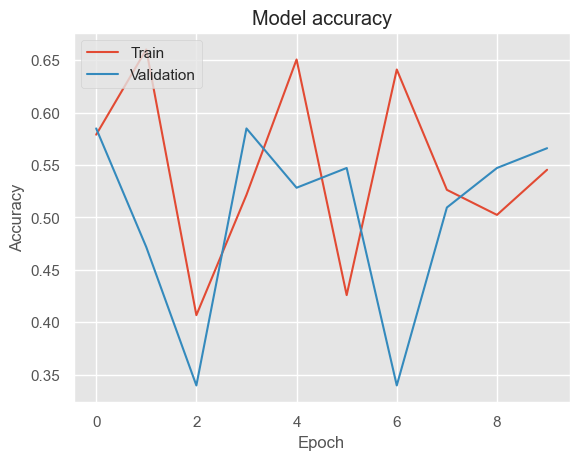

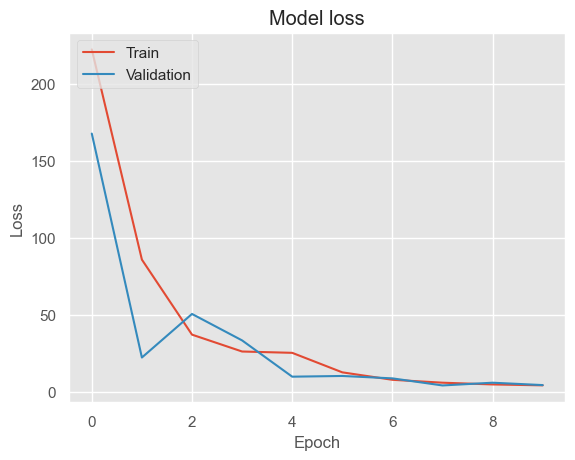

In [77]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()